### Refining using graph mining methods

In [2]:
import os
import copy
import pandas as pd
import networkx as nx
from tqdm import tqdm
from collections import defaultdict
from utils import parse_output, load_label

* load data

In [7]:
PATH = './results/rel_results.jsonl'
import json

llm_res = {'none': [], 
           'irrel': [], 
           'equiv': [], 
           'subcls': [], 
           'inverse': []}

with open(PATH, 'r') as file:
    for line in file:
        block = json.loads(line.strip())
        rels = tuple(block["cls_pairs"]) # (parent, child)
        ans = parse_output(block["answer"])
        if ans.startswith('['):
            if ans == '[NONE]':
                llm_res['none'].append(rels)
            elif ans == '[IRREL]':
                llm_res['irrel'].append(rels)
            elif ans == '[EQUIV]':
                llm_res['equiv'].append(rels)
            elif ans == '[SUBCLS]':
                llm_res['subcls'].append(rels)
            elif ans == '[INVERSE]':
                llm_res['inverse'].append(rels)
            else:
                raise ValueError(f"Answer not valid: {ans}")
        else:
            raise ValueError(f"Answer not valid: {ans}")

# statistics
total = len(llm_res['none']+llm_res['irrel']+llm_res['equiv']+llm_res['subcls']+llm_res['inverse'])
print(f"None: {len(llm_res['none'])}, Percentage: {len(llm_res['none'])/total*100:.2f}%")
print(f"Irrelevant: {len(llm_res['irrel'])}, Percentage: {len(llm_res['irrel'])/total*100:.2f}%")
print(f"Equivalent: {len(llm_res['equiv'])}, Percentage: {len(llm_res['equiv'])/total*100:.2f}%")
print(f"Subclass: {len(llm_res['subcls'])}, Percentage: {len(llm_res['subcls'])/total*100:.2f}%")
print(f"Inverse: {len(llm_res['inverse'])}, Percentage: {len(llm_res['inverse'])/total*100:.2f}%")
        

None: 3354, Percentage: 6.35%
Irrelevant: 6741, Percentage: 12.76%
Equivalent: 1364, Percentage: 2.58%
Subclass: 39800, Percentage: 75.34%
Inverse: 1567, Percentage: 2.97%


* refinement using graph mining

In [24]:
DATA_PATH = './data/wikidata/'
GRAPH_PATH = './data/taxonomies/'
root = 'wd:Q35120' # entity
cls2label = load_label(DATA_PATH+'wiki_taxonomy_labels.tsv')

Is DAG? True
Is connected? True
Max Depth: 15
Number of roots: 1
Number of edges: 52826
Number of nodes: 38261


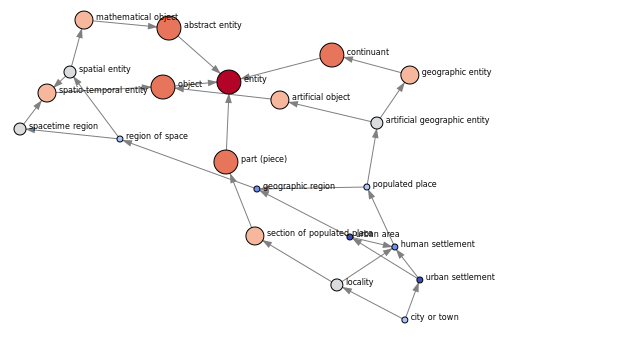

In [25]:
# load taxonomy graph
from graph_utils import bfs_edges_by_level
from graph_utils import save_graph_checkpoint, draw_graph

topwikitaxonUp = defaultdict(set)
topWikitaxonDown = defaultdict(set)
with open(DATA_PATH+'noisy_WiKC.tsv', 'r') as topreader:
    for line in topreader:
        triple = line.strip().split('\t')
        if len(triple) > 3:
            child, parent = triple[0], triple[2]
            topwikitaxonUp[child].add(parent)
            topWikitaxonDown[parent].add(child)

# Graph properties
graph = nx.DiGraph(topWikitaxonDown)
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source=root).values()))
print("Number of roots:", len([node for node in graph.nodes() if not list(graph.predecessors(node))]))
print("Number of edges:", graph.number_of_edges())
print("Number of nodes:", graph.number_of_nodes())
# draw an extract
save_graph_checkpoint(graph, GRAPH_PATH, 'original.tsv')
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

In [10]:
from data_mining_scripts.utils import load_taxonomy
from data_mining_scripts.utils import cumulative_stats

# load statistics
cls_inst_count = pd.read_csv(DATA_PATH + 'cls_inst_count.txt', sep='\t', header=None, names=['cls', 'count']).set_index('cls').to_dict()['count']
_, oriwikiUp = load_taxonomy(DATA_PATH + "wiki_taxonomy.tsv")
cum_cls_inst_stats = cumulative_stats(cls_inst_count, oriwikiUp)
ori_cls_stats = defaultdict(int) # updated cls instance stats
for node in graph.nodes():
    if graph.out_degree(node) == 0:
        # leaf node
        ori_cls_stats[node] = cum_cls_inst_stats[node]
    else:
        if node in cls_inst_count:
            ori_cls_stats[node] = cls_inst_count[node]

* Cut

Current Step (1): Cut Strategy.: 100%|██████████| 52826/52826 [16:14<00:00, 54.23it/s]  


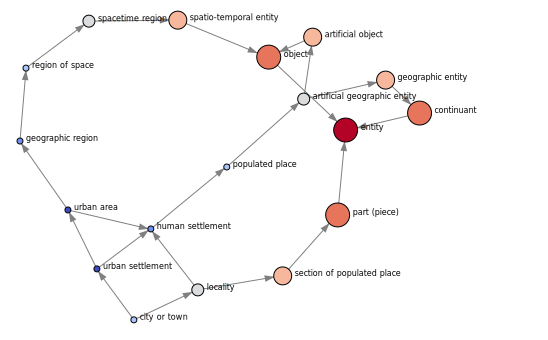

In [26]:
# Cut Strategy
edges_del = set(llm_res['irrel'] + llm_res['none'])
bfs_edges = bfs_edges_by_level(graph, 'wd:Q35120')
for edge in tqdm(bfs_edges, desc='Current Step (1): Cut Strategy.'):
    # Skip first-level classes
    if edge[0] == root:
        continue
    
    if graph.has_edge(edge[0], edge[1]) and (edge in edges_del):
        if graph.in_degree(edge[1]) > 1:
            # remove edge if child has multiple parents
            graph.remove_edge(edge[0], edge[1])
            continue
        else:
            graph.remove_edge(edge[0], edge[1])
            if not nx.is_weakly_connected(graph):
                components = list(nx.weakly_connected_components(graph))
                assert len(components) == 2
                if len(components[1]) < len(components[0]) and len(components[1]) < 4: 
                    # remove small subgraph with <= 3 nodes
                    for node in components[1]:
                        graph.remove_node(node)
                    continue
                graph.add_edge(edge[0], edge[1])
            elif not nx.has_path(graph, root, edge[1]):
                # weakly connected but having multiple roots
                del_nodes_set = set()
                for node in graph.nodes():
                    if not nx.has_path(graph, root, node):
                        del_nodes_set.add(node)
                    if len(del_nodes_set) > 5:
                        # no delete anymore
                        graph.add_edge(edge[0], edge[1])
                        break
                # delete nodes which is root unreachable
                if len(del_nodes_set) <= 5:
                    for node in del_nodes_set:
                        if graph.has_node(node):
                            graph.remove_node(node)

# save graph checkpoint
save_graph_checkpoint(graph, GRAPH_PATH, 'cutting.tsv')
# draw an extract
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

In [27]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 19
Number of roots: 1


(41360, 33020)

* resolve

Current Step (2): Resolve Strategy.: 100%|██████████| 41360/41360 [01:37<00:00, 423.62it/s] 


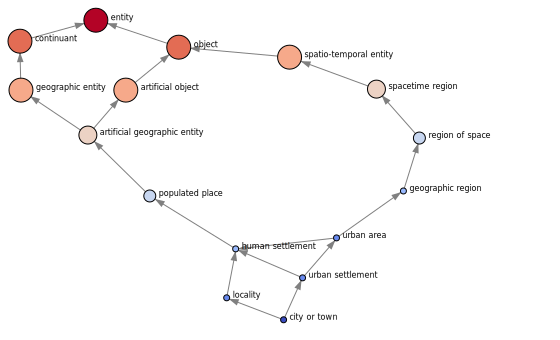

In [28]:
# Initialize a mapping dict
mapping = defaultdict(set) # WiKC -> Wikidata
# Resolve Strategy
inverse_edges = set(llm_res['inverse'])
bfs_edges = bfs_edges_by_level(graph, 'wd:Q35120')
inv_del_edges = []
for edge in tqdm(bfs_edges, desc='Current Step (2): Resolve Strategy.'):
    parent, child = edge
    if edge not in inverse_edges:
        continue
    if graph.has_edge(parent, child):
        if graph.in_degree(child) > 1:
            graph.remove_edge(parent, child) # cut edge
            inv_del_edges.append(edge)
        else: # merge child to parent (single parent)
            for sc in graph.successors(child):
                graph.add_edge(parent, sc)
            graph.remove_node(child)
            # save mapping
            mapping[parent].add(child)
    if not nx.is_weakly_connected(graph):
        print('Not connected if remove edge:', edge)
        break

# save graph checkpoint
save_graph_checkpoint(graph, GRAPH_PATH, 'resolving.tsv')
# draw an extract
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

In [29]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 15
Number of roots: 1


(39877, 32197)

* reduce

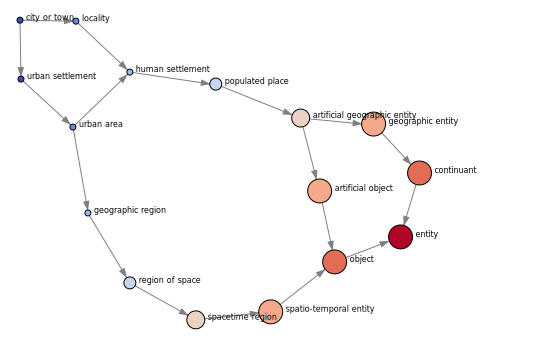

In [30]:
# Post-processing after cutting and resolving
graph = nx.transitive_reduction(graph)
# save graph checkpoint
save_graph_checkpoint(graph, GRAPH_PATH, 'reducing.tsv')
# draw an extract
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

In [31]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(37528, 32197)

* merge

Current Step (4): Merge Strategy.: 100%|██████████| 37528/37528 [18:16<00:00, 34.24it/s]  


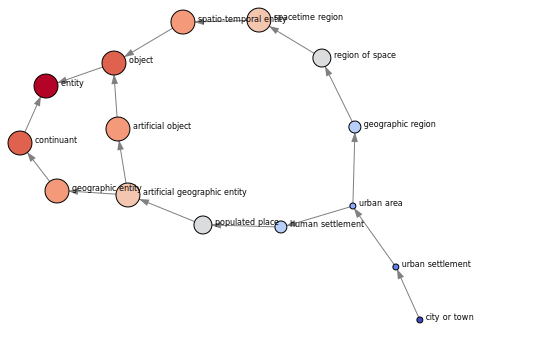

In [32]:
# exact match + equivalent edges
exact_match_edges = []
for edge in graph.edges():
    parent, child = cls2label[edge[0]], cls2label[edge[1]]
    if parent.lower() == child.lower():
        exact_match_edges.append(edge)
equiv_edges = set(llm_res['equiv'] + exact_match_edges)

# Merge Strategy
mergemap = {} # child -> parent merge map
relinkedParentTo = set() # reprompt edges
bfs_edges = bfs_edges_by_level(graph, root)
for edge in tqdm(bfs_edges, desc='Current Step (4): Merge Strategy.'):
    # we won't merge the first-level classes
    # e.g. entity -> object
    if edge[0] == root:
        continue
    # we won't consider continuous merge
    if not graph.has_edge(edge[0], edge[1]):
        continue
    if edge in set(equiv_edges):
        cur = edge[1]
        mergeTo = edge[0]
        # find the first valid parent, avoid already merged parent
        while mergeTo in mergemap:
            mergeTo = mergemap[mergeTo]
        for sc in graph.successors(cur):
            graph.add_edge(mergeTo, sc)
        for pc in graph.predecessors(cur):
            # avoid duplicates and contradiction
            if nx.has_path(graph, source=pc, target=mergeTo) or \
                nx.has_path(graph, source=mergeTo, target=pc):
                continue
            if pc == edge[0]:
                continue
            if graph.has_node(pc) and graph.has_node(mergeTo):
                relinkedParentTo.add(tuple([pc, mergeTo]))
        # delete current node
        mergemap[cur] = mergeTo
        mapping[mergeTo].add(cur) # save mapping WiKC -> Wikidata
        graph.remove_node(cur)
        # transitive reduction
        graph = nx.transitive_reduction(graph)


# save graph checkpoint
save_graph_checkpoint(graph, GRAPH_PATH, 'merging.tsv')
# draw an extract
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

In [33]:
# save the WiKC -> Wikidata mapping to a file
for node in graph.nodes():
    mapping[node].add(node)
with open('./data/wikc_wikidata_mapping.tsv', 'w') as file:
    for k in mapping.keys():
        for cls in mapping[k]:
            file.write(f"{k}\t{cls}\n")

* rewire

Number of edges to be reprompted: 281
Number of edges to be rewired: 125


Current Step (5): Rewire Strategy.: 100%|██████████| 125/125 [00:00<00:00, 226768.17it/s]


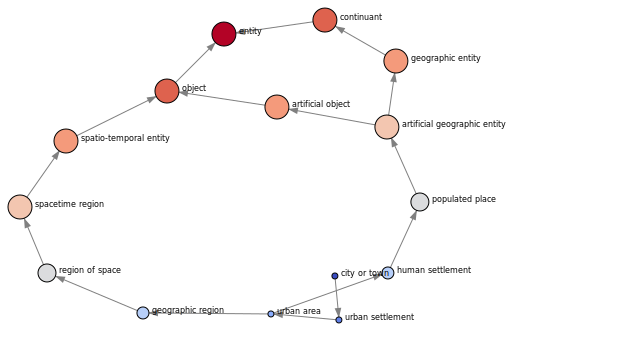

In [39]:
# Rewire Strategy
print('Number of edges to be reprompted:', len(relinkedParentTo)) # (parent, child)
# save reprompted edges
with open('./data/reprompt_edges.tsv', 'w') as file:
    for edge in relinkedParentTo:
        parent, child = edge
        file.write(f"{child}\trdfs:subClassOf\t{parent}\t.\n")

# Then run the reprompt.py for the reprompting results
# !python reprompt.py

# check if results exist
if not os.path.exists('./results/reprompt.jsonl'):
    raise FileNotFoundError('Please reprompt on LLM firstly.')

# get reprompt results
torelink_edges = [] # (parent, child) pairs
with open('./results/reprompt.jsonl', 'r') as file:
    for line in file:
        block = json.loads(line.strip())
        rels = tuple(block["cls_pairs"])
        ans = parse_output(block["answer"])
        if ans.startswith('['):
            if ans == '[SUBCLS]':
                torelink_edges.append(rels)
        else:
            raise ValueError(f"Answer not valid: {ans}")

print('Number of edges to be rewired:', len(torelink_edges))

# relink only [SUBCLS] edges
for edge in tqdm(torelink_edges, desc='Current Step (5): Rewire Strategy.'):
    parent, child = edge
    if graph.has_node(parent) and graph.has_node(child):
        if graph.has_edge(parent, child):
            continue
        graph.add_edge(parent, child)
graph = nx.transitive_reduction(graph)

# save graph checkpoint
save_graph_checkpoint(graph, GRAPH_PATH, 'rewiring.tsv')
# draw an extract
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

In [91]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 21
Number of roots: 1


(35918, 30949)

* filter

In [97]:
# Filter Strategy
# rare classes
from itertools import permutations
invalid_edges = set(inv_del_edges).union(edges_del)
def _get_valid_ancestors(ori_graph, ancestors, cls, cur_graph):
    for sp in ori_graph.predecessors(cls):
        # path should not include deleted edges
        if tuple([sp, cls]) in invalid_edges:
            continue
        if cur_graph.has_node(sp):
            ancestors.add(sp)
            continue
        _get_valid_ancestors(ori_graph, ancestors, sp, cur_graph)

def _get_first_ancestors(ori_graph, cls, cur_graph):
    ancestors = set()
    _get_valid_ancestors(ori_graph, ancestors, cls, cur_graph)
    return ancestors


# Instance filtering
oriwikiDown, _ = load_taxonomy(DATA_PATH + "wiki_taxonomy.tsv")
ori_wiki = nx.DiGraph(oriwikiDown)
cls_inst_stats = defaultdict(int)
# retyping instances
for cls in tqdm(ori_cls_stats.keys(), desc='Retyping'):
    if graph.has_node(cls):
        cls_inst_stats[cls] += ori_cls_stats[cls]
        continue
    ancestors = list(_get_first_ancestors(ori_wiki, cls, graph))
    if len(ancestors) == 1:
        cls_inst_stats[ancestors[0]] += ori_cls_stats[cls]
        continue
    if len(ancestors) > 0:
        # remove transitive parents
        valcls = ancestors.copy()
        for (node1,node2) in permutations(ancestors, 2):
            if node1 not in valcls or node2 not in valcls:
                continue
            if nx.has_path(graph, node1, node2):
                valcls.remove(node1)
        for c in valcls:
            cls_inst_stats[c] += ori_cls_stats[cls]
# filtering
cum_stats = cumulative_stats(cls_inst_stats, nx.to_dict_of_lists(graph.reverse()))
nodes = list(graph.nodes())
longtail_count = 0
for cls in tqdm(nodes, desc='Current Step (6)-1: Filter classes without cumulative instances.'):
    if cum_stats[cls] < 2:
        # remove classes with at most one instance
        graph.remove_node(cls)
        longtail_count += 1
print(f"Removed {longtail_count} classes with at most one instance.")

Retyping: 100%|██████████| 34647/34647 [00:00<00:00, 147167.59it/s]
Current Step (6)-1: Filter classes without cumulative instances.: 100%|██████████| 30949/30949 [00:00<00:00, 716162.77it/s]

Removed 6487 classes with at most one instance.


In [98]:
# specific top-level classes
topcls = list(graph.successors(root))
for cls in tqdm(topcls, desc='Current Step (6)-2: Filter specific top-level classes.'):
    redundancy = True
    for child in graph.successors(cls):
        parents = set(graph.predecessors(child)) - set(topcls)
        if len(parents) == 0:
            redundancy = False
            break
    if redundancy:
        graph.remove_node(cls) # remove top-level class
print("Current number of top classes:", graph.out_degree(root))

# non-informative classes
from graph_utils import find_non_informative_cls
non_info_cls = find_non_informative_cls(graph, ori_cls_stats)
while len(non_info_cls) > 0:
    # remove non-informative classes recursively
    for node in tqdm(non_info_cls, desc='Current Step (6)-3: Filter non-informative classes.'):
        parent = list(graph.predecessors(node))[0]
        child = list(graph.successors(node))[0]
        graph.remove_node(node)
        if not nx.has_path(graph, parent, child):
            graph.add_edge(parent, child)
    non_info_cls = find_non_informative_cls(graph, ori_cls_stats)
graph = nx.transitive_reduction(graph)

Current Step (6)-2: Filter specific top-level classes.: 100%|██████████| 21/21 [00:00<00:00, 138057.03it/s]


Current number of top classes: 17


Current Step (6)-3: Filter non-informative classes.: 100%|██████████| 913/913 [00:00<00:00, 61783.44it/s]
Current Step (6)-3: Filter non-informative classes.: 100%|██████████| 20/20 [00:00<00:00, 52461.59it/s]


In [99]:
# Filter classes without a Wikipedia page
mapped_wiki_ents = set()
wikipedia_lists = ['enwiki', 'frwiki', 'dewiki', 'zhwiki', 'arwiki'] # 5 different lanugages
for wikifile in wikipedia_lists:
    with open(os.path.join('./data/wikipedia', wikifile), 'r') as file:
        for line in file:
            qid = line.strip().split(',')[1]
            prefix_qid = 'wd:'+str(qid)
            if graph.has_node(prefix_qid):
                mapped_wiki_ents.add(prefix_qid)
# enrich mapped set with classes (depth <= 3)
top3cls = nx.single_source_shortest_path_length(graph, source=root, cutoff=3).keys()
mapped_wiki_ents.update(top3cls)

# rebuild graph based on mapped wiki classes
def _get_mapped_ancestors(digraph, ancestors, cls):
    for sp in digraph.predecessors(cls):
        if sp in mapped_wiki_ents:
            ancestors.add(sp)
            continue
        _get_mapped_ancestors(digraph, ancestors, sp)

def _get_first_ancestors_for_rebuild(digraph, cls):
    ancestors = set()
    _get_mapped_ancestors(digraph, ancestors, cls)
    return ancestors

wikc = nx.DiGraph()
for node in mapped_wiki_ents:
    wikc.add_node(node)
for node in tqdm(mapped_wiki_ents, desc='Current Step (6)-4: Filter classes without a Wikipedia page'):
    ancestors = list(_get_first_ancestors_for_rebuild(graph, node))
    for ancestor in ancestors:
        wikc.add_edge(ancestor, node) # parent -> child
wikc = nx.transitive_reduction(wikc)
graph = copy.deepcopy(wikc) # update

Current Step (6)-4: Filter classes without a Wikipedia page: 100%|██████████| 16581/16581 [00:00<00:00, 270249.57it/s]


In [102]:
print("Is DAG?", nx.is_directed_acyclic_graph(graph))
print("Is connected?", nx.is_weakly_connected(graph))
print("Max Depth:", max(nx.shortest_path_length(graph, source='wd:Q35120').values()))
print("Number of roots:", len([node for node in graph.nodes() if graph.in_degree(node) == 0]))
print("Number of top level classes:", graph.out_degree(root))
graph.number_of_edges(), graph.number_of_nodes()

Is DAG? True
Is connected? True
Max Depth: 13
Number of roots: 1
Number of top level classes: 16


(19622, 16581)

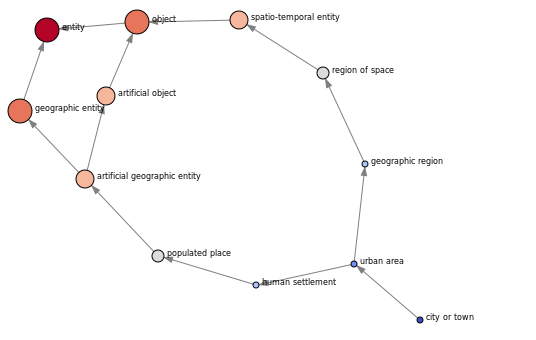

In [104]:
# save graph checkpoint
save_graph_checkpoint(graph, GRAPH_PATH, 'final.tsv')
# draw an extract
city_or_town = 'wd:Q7930989'
draw_graph(graph, city_or_town, cls2label)

* Visualize some important paths

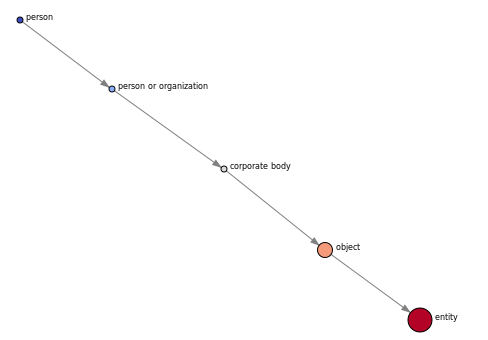

In [70]:
person = 'wd:Q215627'
draw_graph(graph, person, cls2label)

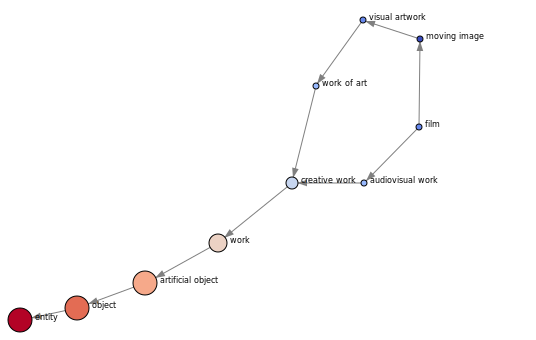

In [75]:
film = 'wd:Q11424'
draw_graph(graph, film, cls2label)

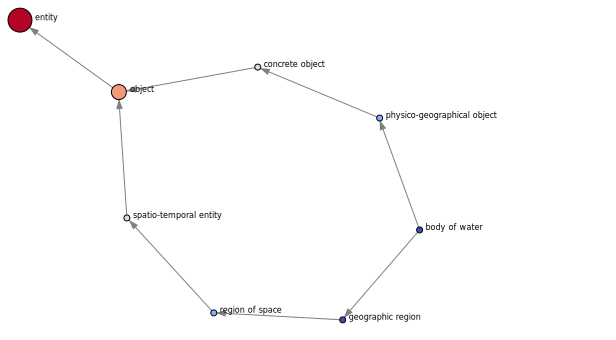

In [74]:
body_of_water = 'wd:Q15324'
draw_graph(graph, body_of_water, cls2label)

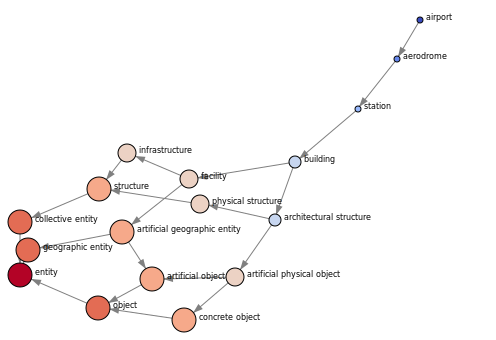

In [77]:
airport = 'wd:Q1248784'
draw_graph(graph, airport, cls2label)

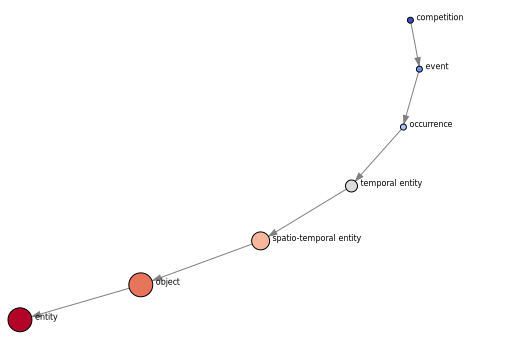

In [78]:
competition = 'wd:Q476300'
draw_graph(graph, competition, cls2label)

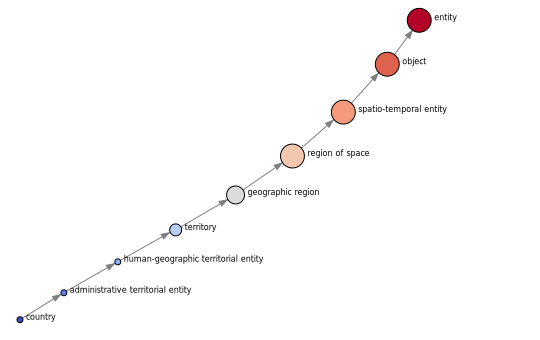

In [80]:
country = 'wd:Q6256'
draw_graph(graph, country, cls2label)

* change taxonomy format

In [2]:
from graph_utils import load_graph_checkpoint, format_taxonomy
wikc = load_graph_checkpoint(GRAPH_PATH, 'final.tsv')
format_taxonomy('./data/', wikc)

In [8]:
import pandas as pd
df = pd.read_csv('./data/wikc_wikidata_mapping.tsv', sep='\t', header=None, names=['wikc', 'wikidata'])
df.to_csv('./data/wikc_wikidata_mapping.tsv', sep='\t', index=False)

In [ ]:
# store deleted edges
invalid_edges = set(inv_del_edges).union(edges_del)
with open('./data/evaluation/edges_del.tsv', 'w') as file:
    for edge in invalid_edges:
        file.write(f"{edge[0]}\t{edge[1]}\n")